# Kaggle 타이타닉
- 이유한님 타이타닉 튜토리얼 필사
- 타이타닉 튜토리얼 1 - Exploratory data analysis, visualization, machine learning https://kaggle-kr.tistory.com/17?category=868316

타이타닉에 탑승한 사람들의 신상정보를 활용하여, 승선한 사람들의 생존여부를 예측하는 모델을 생성해보자.

Process
1. 데이터셋 확인
 - 대부분 캐글 데이터는 잘 정제되어 있지만 가끔 null data가 존재한다. 이를 확인하고 향후 수정한다.
2. 탐색적 데이터 분석(EDA)
 - 여러 feature들을 개별적으로 분석하고, feature들 간의 상관관계를 확인한다.
 - 여러 시각화 툴을 사용하며 insight를 얻는다.
3. feature engineering
 - 모델을 세우기에 앞서, 모델의 성능을 높일 수 있도록 feature들을 engineering 한다.
 - one-hot encoding, class로 나누기, 구간으로 나누기, 텍스트 데이터 처리 등을 한다.
4. model 만들기
 - sklearn을 사용해 모델을 만든다.(머신러닝)
 - 딥러닝을 위해 tensorflow, pytorch 등을 사용할 수도 있음.
5. 모델 학습 및 예측
 - trainset을 가지고 모델을 학습시킨 후 testset으로 prediction한다.
6. 모델 평가
 - 예측 성능이 원하는 수준인지 판단한다.
 - 풀려는 문제에 따라 모델을 평가하는 방식도 달라진다.

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn')
sns.set(font_scale=2.5)
# 이 두 줄을 사용하면 좀 더 편하게 쓸 수 있음. matplotlib의 기본 scheme 말고 seaborn의 scheme을 세팅하고, 일일이 grph의 font_size를 지정할 필요 없이 seaborn의 font_scale을 지정하면 편하다.

import missingno as msno # 결측치 시각화

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## 1. Dataset 확인

In [52]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [53]:
df_train = pd.read_csv('/content/drive/MyDrive/titanic_train.csv')
df_test = pd.read_csv('/content/drive/MyDrive/titanic_test.csv')

In [54]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Feature: Pclass, Age, SibSp, Parch, Fare

target: Survived(생존 여부)

### 변수(Feature) 종류 설명
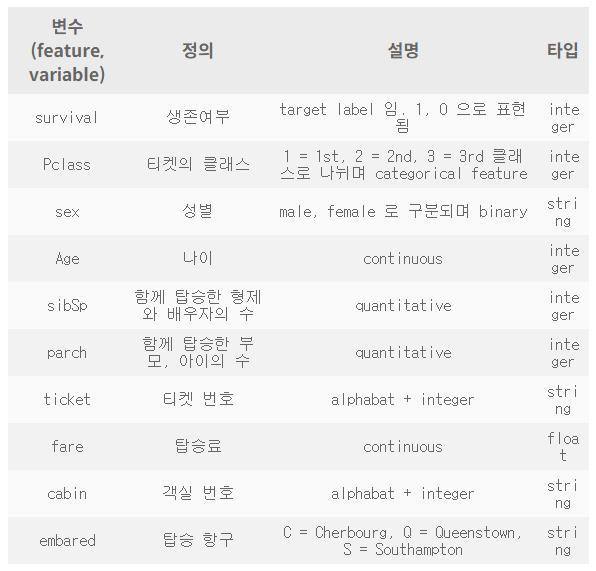

In [55]:
# 각 feature별 통계치 반환
df_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [56]:
df_test.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


### 1.1 Null data check

In [57]:
# 기본 null data 확인
df_train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [58]:
# 백분율로 표시
for col in df_train.columns:
    msg = 'column: {:>10}\t Parcent of NaN value: {:.2f}%'.format(col, 100 * (df_train[col].isnull().sum() / df_train[col].shape[0]))
    print(msg)

column: PassengerId	 Parcent of NaN value: 0.00%
column:   Survived	 Parcent of NaN value: 0.00%
column:     Pclass	 Parcent of NaN value: 0.00%
column:       Name	 Parcent of NaN value: 0.00%
column:        Sex	 Parcent of NaN value: 0.00%
column:        Age	 Parcent of NaN value: 19.87%
column:      SibSp	 Parcent of NaN value: 0.00%
column:      Parch	 Parcent of NaN value: 0.00%
column:     Ticket	 Parcent of NaN value: 0.00%
column:       Fare	 Parcent of NaN value: 0.00%
column:      Cabin	 Parcent of NaN value: 77.10%
column:   Embarked	 Parcent of NaN value: 0.22%


In [59]:
for col in df_test.columns:
    msg = 'column: {:>10}\t Parcent of NaN value: {:.2f}%'.format(col, 100 * (df_test[col].isnull().sum() / df_test[col].shape[0]))
    print(msg)

column: PassengerId	 Parcent of NaN value: 0.00%
column:     Pclass	 Parcent of NaN value: 0.00%
column:       Name	 Parcent of NaN value: 0.00%
column:        Sex	 Parcent of NaN value: 0.00%
column:        Age	 Parcent of NaN value: 20.57%
column:      SibSp	 Parcent of NaN value: 0.00%
column:      Parch	 Parcent of NaN value: 0.00%
column:     Ticket	 Parcent of NaN value: 0.00%
column:       Fare	 Parcent of NaN value: 0.24%
column:      Cabin	 Parcent of NaN value: 78.23%
column:   Embarked	 Parcent of NaN value: 0.00%


- train, test set에서 Age(둘 다 약 20%), Cabin(둘 다 약 80%), Embarked(Train만 0.22%) null 데이터가 존재하는 것을 볼 수 있다.

- MSNO 라는 라이브러리를 사용하면 시각화를 통해 null data의 존재를 더 쉽게 볼 수 있다.

<Axes: >

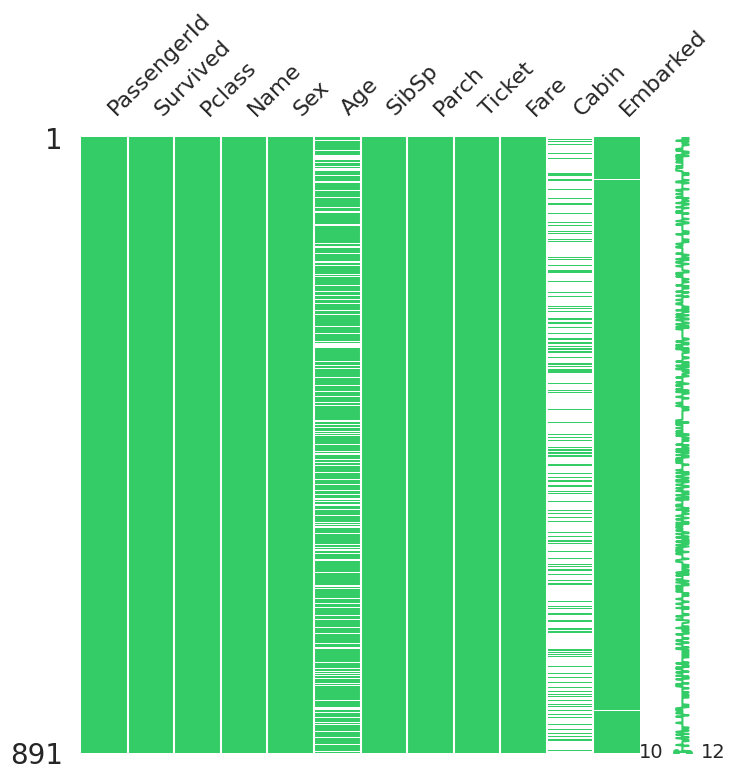

In [60]:
msno.matrix(df=df_train.iloc[:, :], figsize=(8, 8), color=(0.2, 0.8, 0.4))

<Axes: >

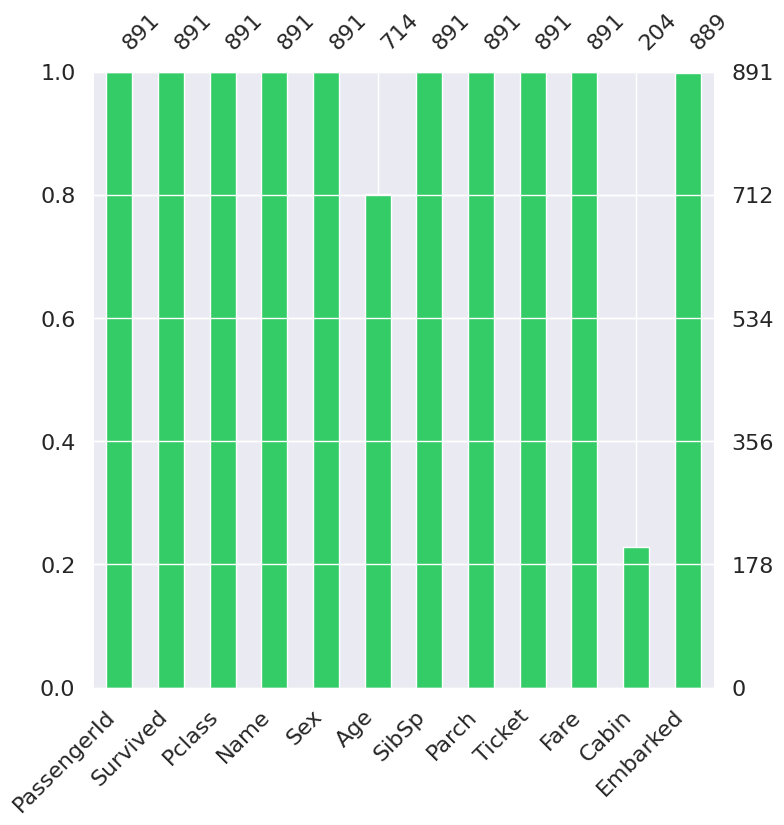

In [61]:
msno.bar(df=df_train.iloc[:, :], figsize=(8, 8), color=(0.2, 0.8, 0.4))

<Axes: >

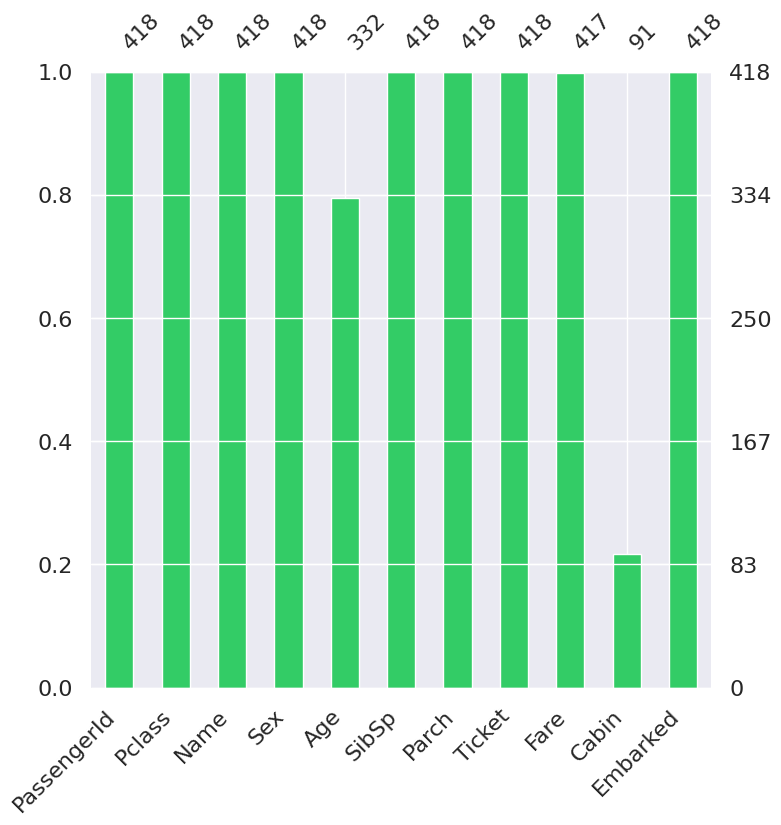

In [62]:
msno.bar(df=df_test.iloc[:, :], figsize=(8, 8), color=(0.2, 0.8, 0.4))

### 1.2 Target label 확인
- Target 레이블이 어떤 distribution을 가지고 있는지 확인해봐야 함
- 지금 같은 binary classification 문제의 경우에서, 1과 0의 분포가 어떠냐에 따라 모델의 평가 방법이 달라질 수 있음

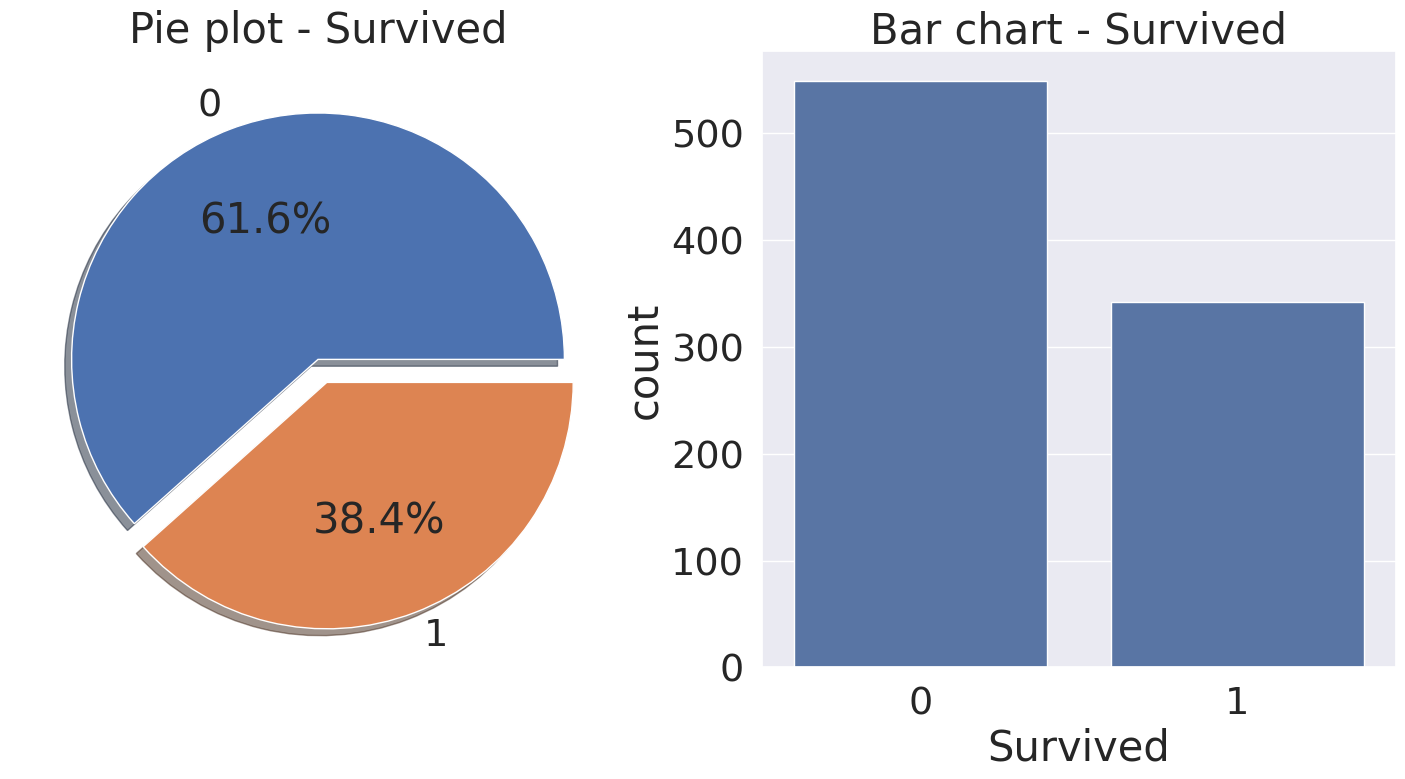

In [64]:
f, ax = plt.subplots(1, 2, figsize=(18, 8))

df_train['Survived'].value_counts().plot.pie(explode=[0, 0.1], autopct='%1.1f%%', ax=ax[0], shadow=True)
ax[0].set_title('Pie plot - Survived')
ax[0].set_ylabel('')
sns.countplot(x='Survived', data=df_train, ax=ax[1]) # countplot 쓸 때 'Survived'가 아니라 x='Survived' 이렇게 레이블을 명시해줘야 error가 없다.
ax[1].set_title('Bar chart - Survived')

plt.show()

- 38.4%가 살아남았다.
- Target label의 분포가 제법 균일(balanced)하다.
- 불균일할 경우, 예를 들어 100 중 1이 99, 이 1개인 경우에는 만약 모델이 모든 것을 1이라고 해도 정확도가 99%가 나오는 경우가 생김.
- 이 경우에 0을 찾는 문제라면 원하는 결과를 낼 수 없게 됨.
- 여기서는 분포가 균일하니 계속 진행한다.

## 2. EDA(Exploratory Data Analysis)
- 탐색적 데이터 분석

### 2.1 Pclass(티켓의 클래스)
- 서수형 데이터 타입(ordinal)
- 카테고리형이면서, 순서가 있는 데이터 타입
- **Pclass에 따른 생존률의 차이 살펴보기**
 - 엑셀의 피벗 차트와 유사한 작업
 - pandas에서는 groupby를 사용하면 좋다.
 - pivot이라는 메소드도 사용

- 'Pclass', 'Survived'를 가져온 후, pclass로 묶는다.
 - 각 pclass마다 0, 1이 카운트되고, 이를 평균내면 각 pclass별 생존률이 나온다.
 - `count()`: 각 class에 몇 명이 있는지 확인할 수 있다. (생존자, 사망자 포함)
 - `sum()`: 216명 중 생존한(survived=1) 사람의 총합

In [67]:
df_train[['Pclass', 'Survived']].groupby(['Pclass'], as_index=True).count()

,Survived
Pclass,
1,216
2,184
3,491


- 'Survived' 칼럼에서 사망자는 0으로, 생존자는 1로 표시되기 때문에, sum()으로 해당 칼럼의 값을 합산하면 각 그룹별 생존자의 수를 구할 수 있다.

In [68]:
df_train[['Pclass', 'Survived']].groupby(['Pclass'], as_index=True).sum()

,Survived
Pclass,
1,136
2,87
3,119


- Pandas의 crosstab을 사용하면 데이터의 교차 빈도를 쉽게 볼 수 있다.
- pd.crosstab: 교차표 생성
- 첫 번째 인자 df_train['Pclass']
 - 교차표의 행 인덱스. 티켓 클래스(Pclass)를 기준으로 함
- 두 번째 인자 df_train['Survived']
 - 교차표의 열 인덱스. 생존 여부(Survived)를 기준으로 함

- margins=True: 'All'이라는 합계 행, 열을 추가함
- style.background_gradient(): 값이 클수록 진한 색으로 표시해 시각적으로 보기 쉽게 만들어준다.

In [69]:
pd.crosstab(df_train['Pclass'], df_train['Survived'], margins=True).style.background_gradient(cmap='summer_r')

Survived,0,1,All
Pclass,,,
1,80,136,216
2,97,87,184
3,372,119,491
All,549,342,891


In [74]:
df_train[['Pclass', 'Survived']].groupby(['Pclass'], as_index=True).mean().sort_values(by='Survived', ascending=False)

,Survived
Pclass,
1,0.629630
2,0.472826
3,0.242363


<Axes: xlabel='Pclass'>

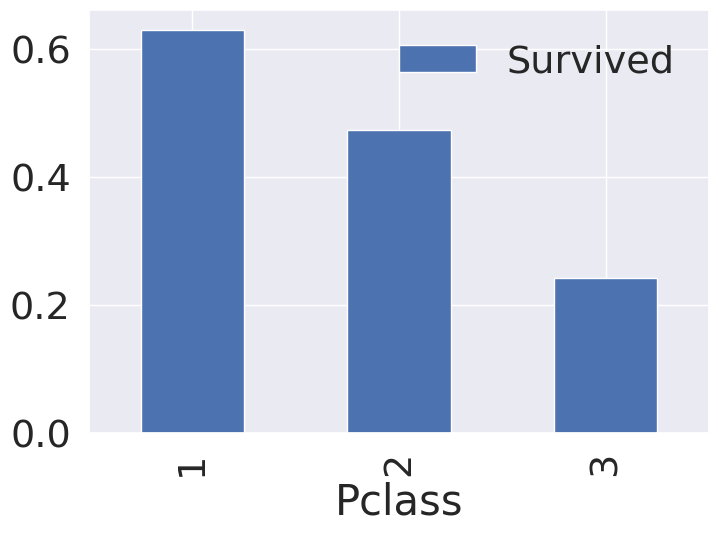

In [70]:
df_train[['Pclass', 'Survived']].groupby(['Pclass'], as_index=True).mean().sort_values(by='Survived', ascending=False).plot.bar()

- **해석: Pclass가 좋을수록(1등석) 생존률이 높다.**
- 좀 더 보기 쉽게 seaborn의 countplot을 이용하여 특정 label에 따른 개수를 확인해본다.

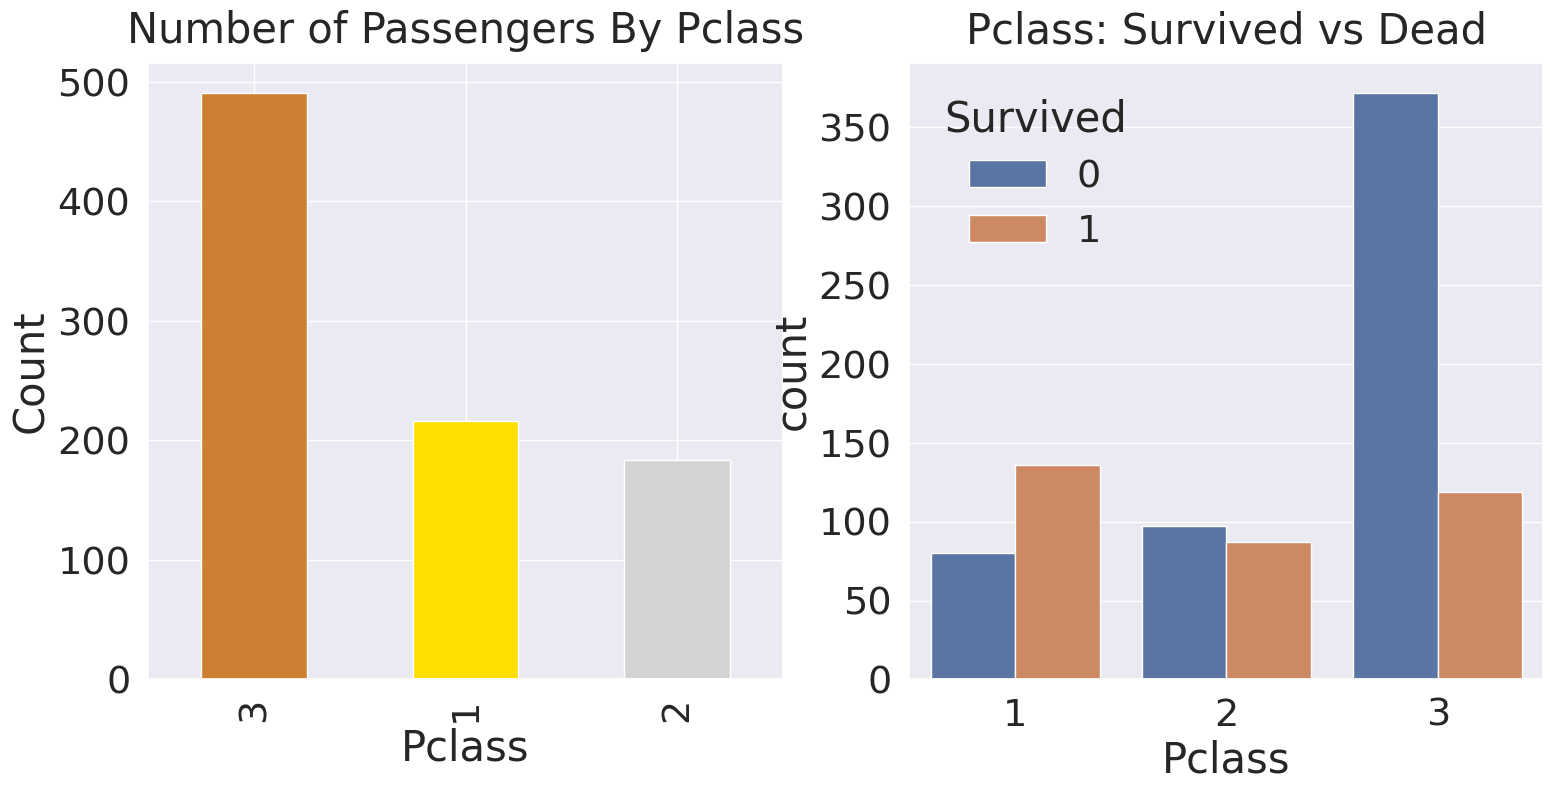

In [73]:
y_position = 1.02
f, ax = plt.subplots(1, 2, figsize=(18, 8))
df_train['Pclass'].value_counts().plot.bar(color=['#CD7F32','#FFDF00','#D3D3D3'], ax=ax[0])
ax[0].set_title('Number of Passengers By Pclass', y=y_position)
ax[0].set_ylabel('Count')
sns.countplot(x='Pclass', hue='Survived', data=df_train, ax=ax[1])
ax[1].set_title('Pclass: Survived vs Dead', y=y_position)
plt.show()

- 클래스가 높을 수록, 생존 확률이 높은걸 확인할 수 있다.
- Pclass 1, 2, 3 순서대로 생존률은 63%, 48%, 25%이다.
- **따라서 생존에 Pclass 가 큰 영향을 미친다고 생각해볼 수 있으며, 나중에 모델을 세울 때 이 feature 를 사용하는 것이 좋을 것이라 판단할 수 있다.**

### 2.2 Sex
- **성별에 따른 생존률의 차이 살펴보기**

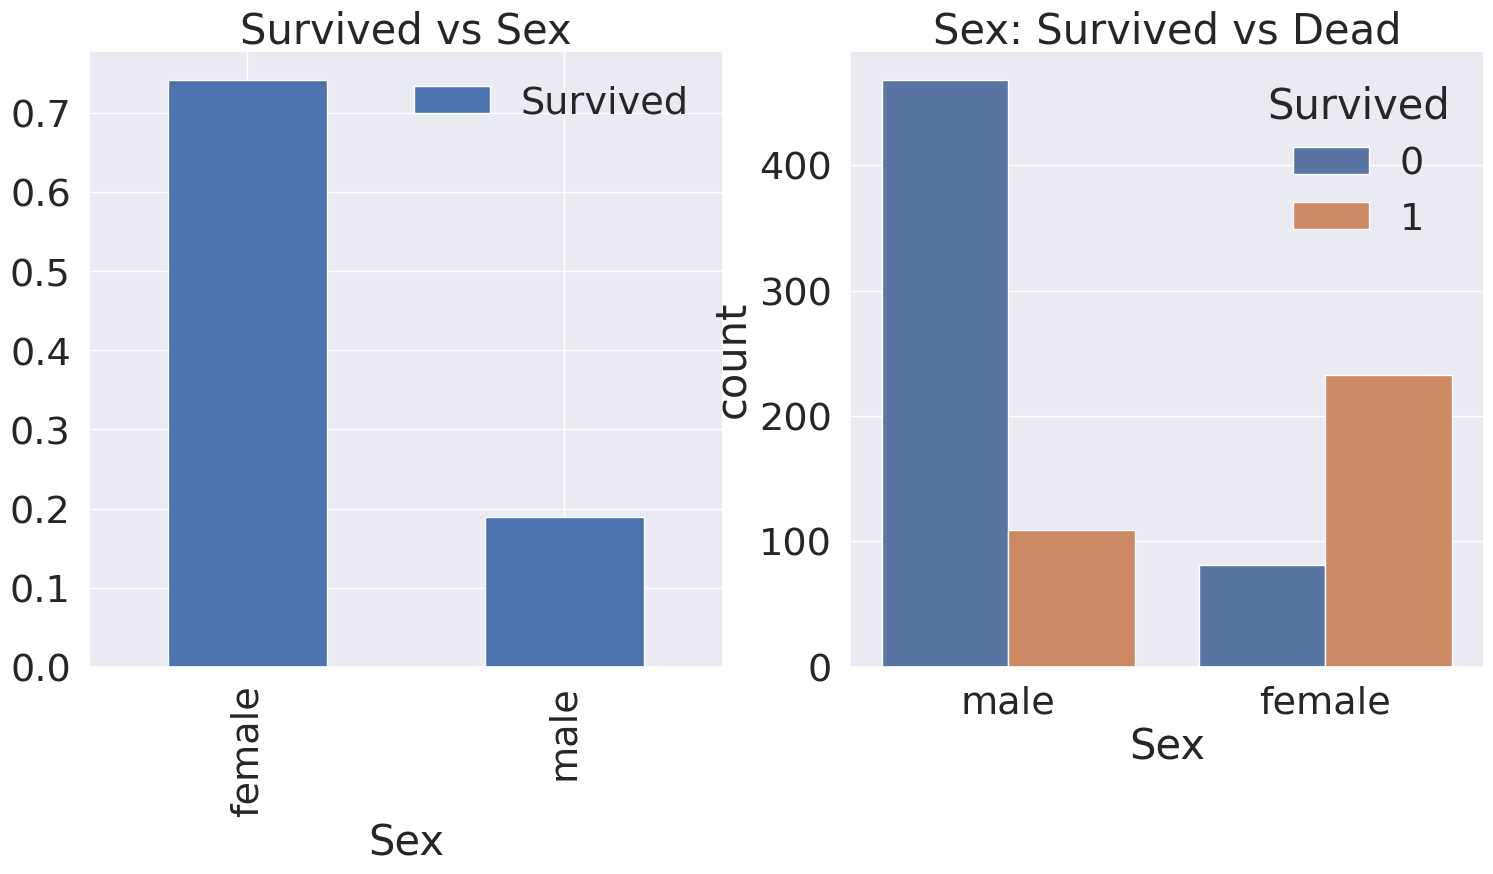

In [75]:
f, ax = plt.subplots(1, 2, figsize=(18, 8))
df_train[['Sex', 'Survived']].groupby(['Sex'], as_index=True).mean().plot.bar(ax=ax[0])
ax[0].set_title('Survived vs Sex')
sns.countplot(x='Sex', hue='Survived', data=df_train, ax=ax[1])
ax[1].set_title('Sex: Survived vs Dead')
plt.show()

- 여자가 생존할 확률이 더 높다.

In [77]:
df_train[['Sex', 'Survived']].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [78]:
pd.crosstab(df_train['Sex'], df_train['Survived'], margins=True).style.background_gradient(cmap='summer_r')

Survived,0,1,All
Sex,,,
female,81,233,314
male,468,109,577
All,549,342,891


- Pclass와 마찬가지로, Sex도 예측 모델에 쓰일 중요한 피처임을 알 수 있다.

### 2.3 Both Sex and Pclass
- 성별(Sex), 티켓 클래스(Pclass) 두 가지에 관해서 생존률이 어떻게 달라지는지 확인
- seaborn의 factorplot을 이용하면 손쉽게 3개의 차원으로 이루어진 그래프를 그릴 수 있다.

**- 현재 seaborn 버전에서 factorplot은 없어졌다고 한다. 대신 catplot을 사용했다.**

In [79]:
sns.factorplot('Pclass', 'Survived', hue='Sex', data=df_train,
               size=6, aspect=1.5)

AttributeError: module 'seaborn' has no attribute 'factorplot'

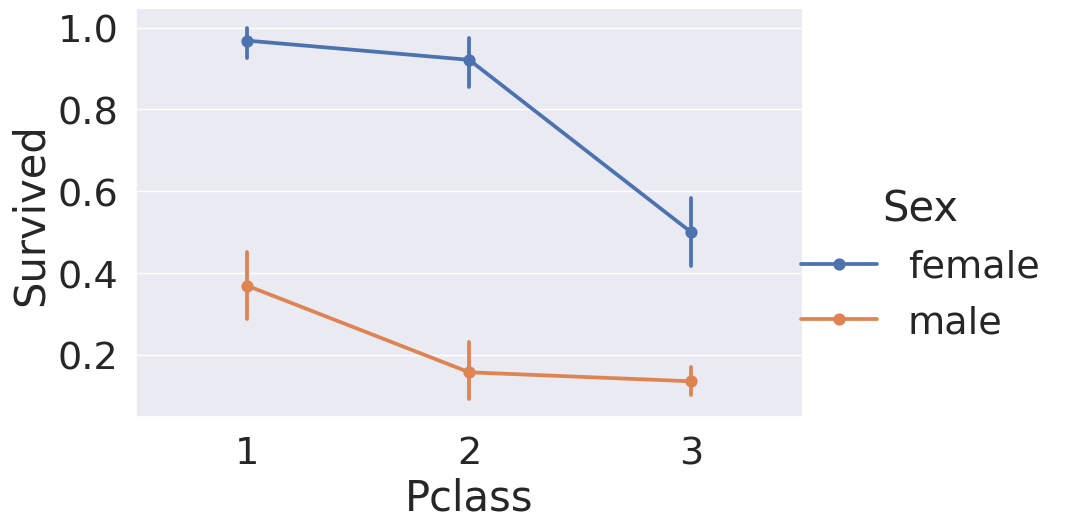

In [80]:
sns.catplot(x='Pclass', y='Survived', hue='Sex', data=df_train, kind='point', height=6, aspect=1.5)

- 모든 클래스에서 female이 살 확률이 male보다 높다.
- 또한 남녀 상관없이 클래스가 높을수록 살 확률이 높다.
- 위 그래프는 hue 대신 column으로 하면 아래와 같아진다.
 - Pclass별로 3개의 subplot을 만듦
 - hue는 동일한 plot 내에서 그룹을 색깔로 구분함(여기서는 성별)

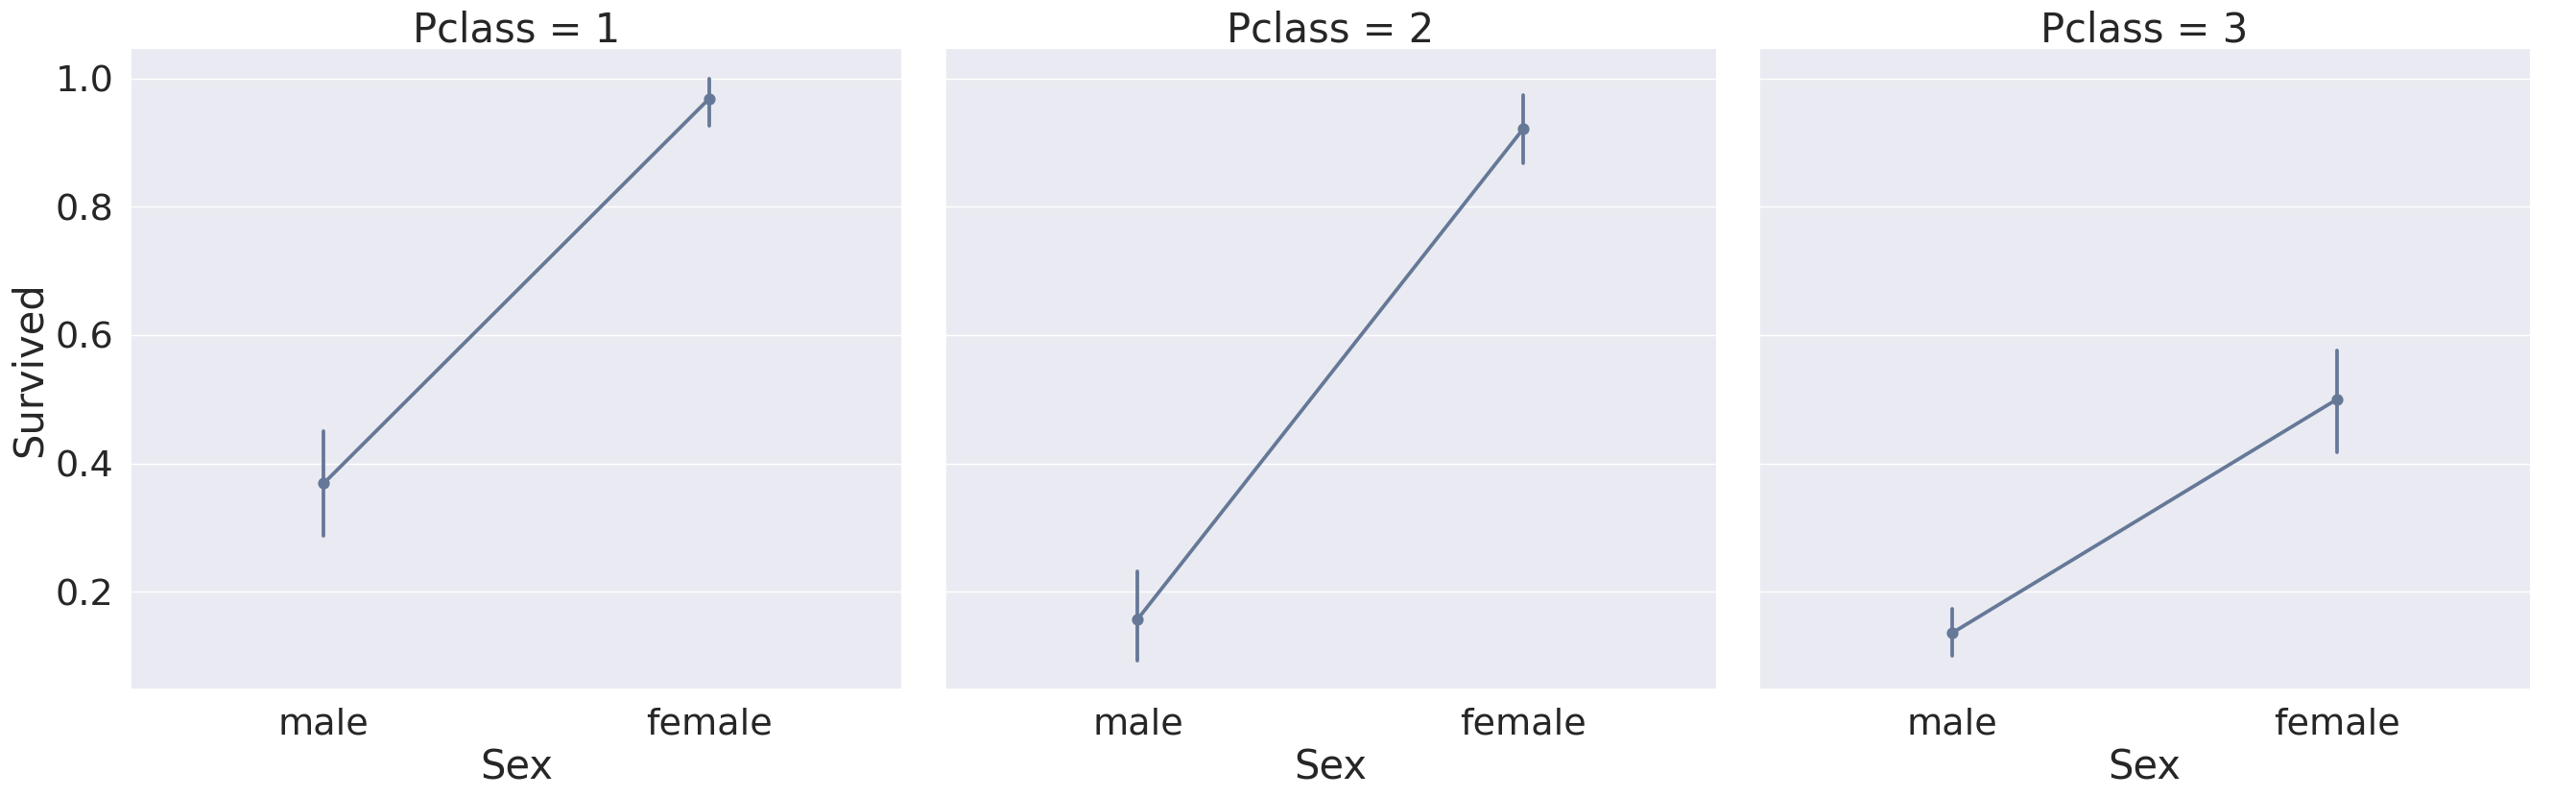

In [81]:
sns.catplot(x='Sex',y='Survived', col='Pclass', data=df_train, saturation=.5, height=9, aspect=1, kind='point')

### 2.4 Age

In [82]:
print('제일 나이 많은 탑승객 : {:.1f} Years'.format(df_train['Age'].max()))
print('제일 어린 탑승객 : {:.1f} Years'.format(df_train['Age'].min()))
print('탑승객 평균 나이 : {:.1f} Years'.format(df_train['Age'].mean()))

제일 나이 많은 탑승객 : 80.0 Years
제일 어린 탑승객 : 0.4 Years
탑승객 평균 나이 : 29.7 Years


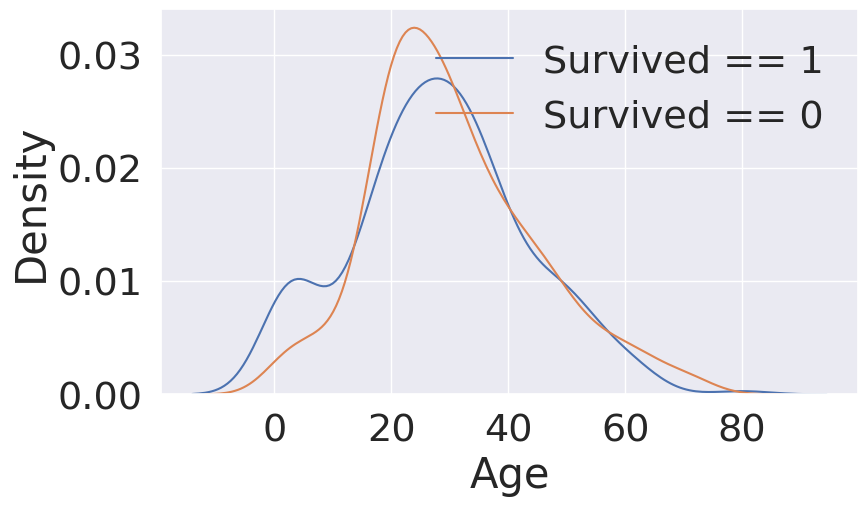

In [83]:
fig, ax = plt.subplots(1, 1, figsize=(9, 5))
sns.kdeplot(df_train[df_train['Survived'] == 1]['Age'], ax=ax)
sns.kdeplot(df_train[df_train['Survived'] == 0]['Age'], ax=ax)
plt.legend(['Survived == 1', 'Survived == 0'])
plt.show()

- 생존자 중 나이가 어린 경우가 많다.

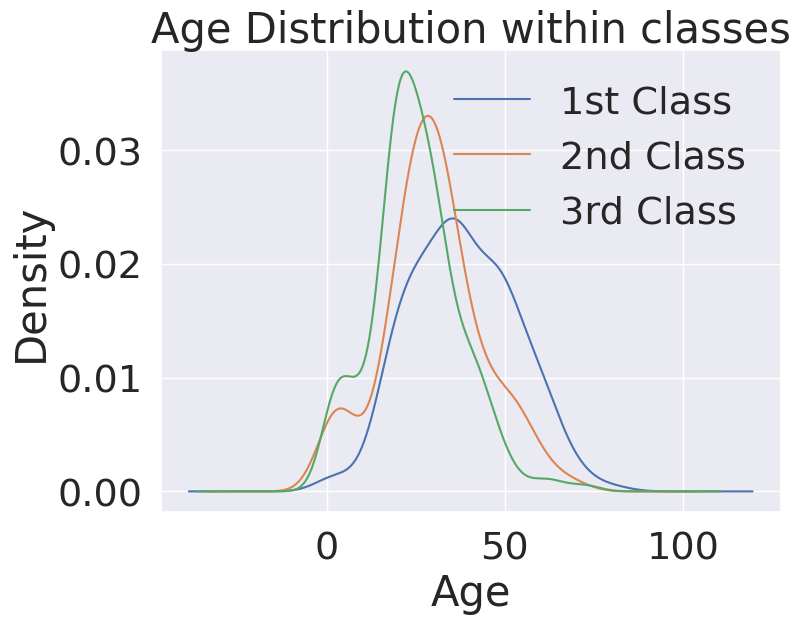

In [84]:
# Age distribution withing classes
plt.figure(figsize=(8, 6))
df_train['Age'][df_train['Pclass'] == 1].plot(kind='kde')
df_train['Age'][df_train['Pclass'] == 2].plot(kind='kde')
df_train['Age'][df_train['Pclass'] == 3].plot(kind='kde')

plt.xlabel('Age')
plt.title('Age Distribution within classes')
plt.legend(['1st Class', '2nd Class', '3rd Class'])

- **class가 높을수록 나이 많은 사람의 비중이 커진다.**
- 다음으로 나이대가 변하면서 생존률이 어떻게 변하는지 살펴본다.
- 나이 범위를 점점 넓혀나가면서 비교한다.

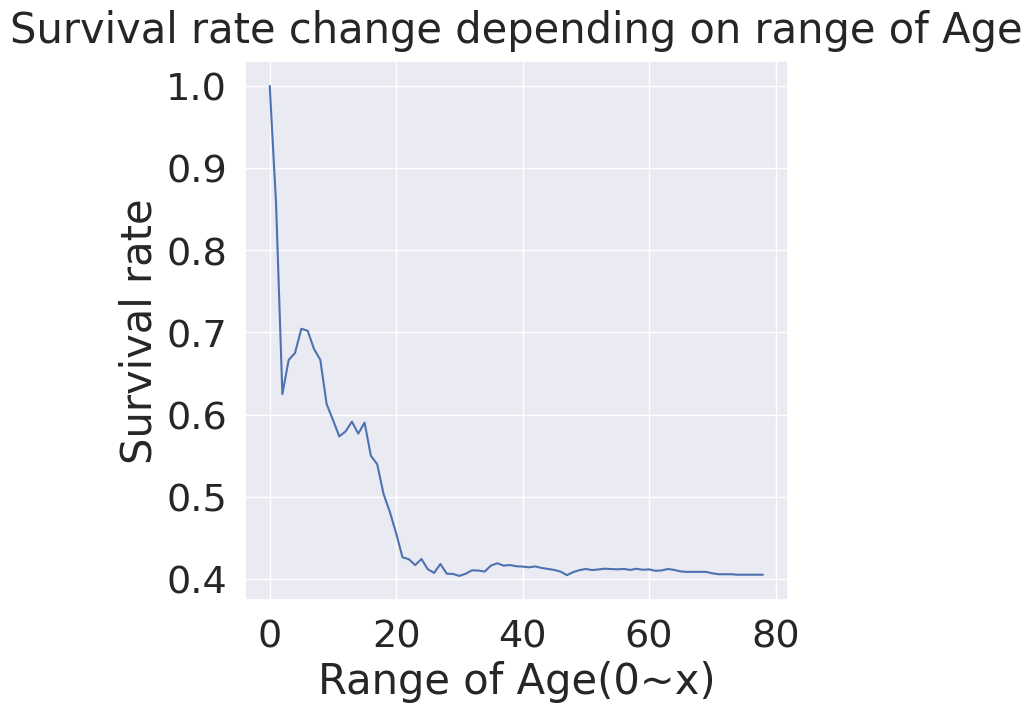

In [89]:
cummulate_survival_ratio = []
for i in range(1, 80):
    cummulate_survival_ratio.append(df_train[df_train['Age'] < i]['Survived'].sum() / len(df_train[df_train['Age'] < i]['Survived']))

plt.figure(figsize=(7, 7))
plt.plot(cummulate_survival_ratio)
plt.title('Survival rate change depending on range of Age', y=1.02)
plt.ylabel('Survival rate')
plt.xlabel('Range of Age(0~x)')
plt.xticks(range(0, 81, 20))
plt.show()

- **나이가 어릴수록 생존률이 확실히 높은 것을 확인할 수 있다.**
- 나이가 중요한 feature로 쓰일 수 있다.

### 2.5 Pclass, Sex, Age

- 지금까지 본 Sex, Pclass, Age, Survived 모두에 대해서 함께 살펴보려고 한다.
- Seaborn 의 violinplot을 사용한다.

- x축은 우리가 나눠서 보고 싶어하는 case(여기선 Pclass, Sex)를 나타내고, y축은 보고 싶어하는 distribution(Age)이다.

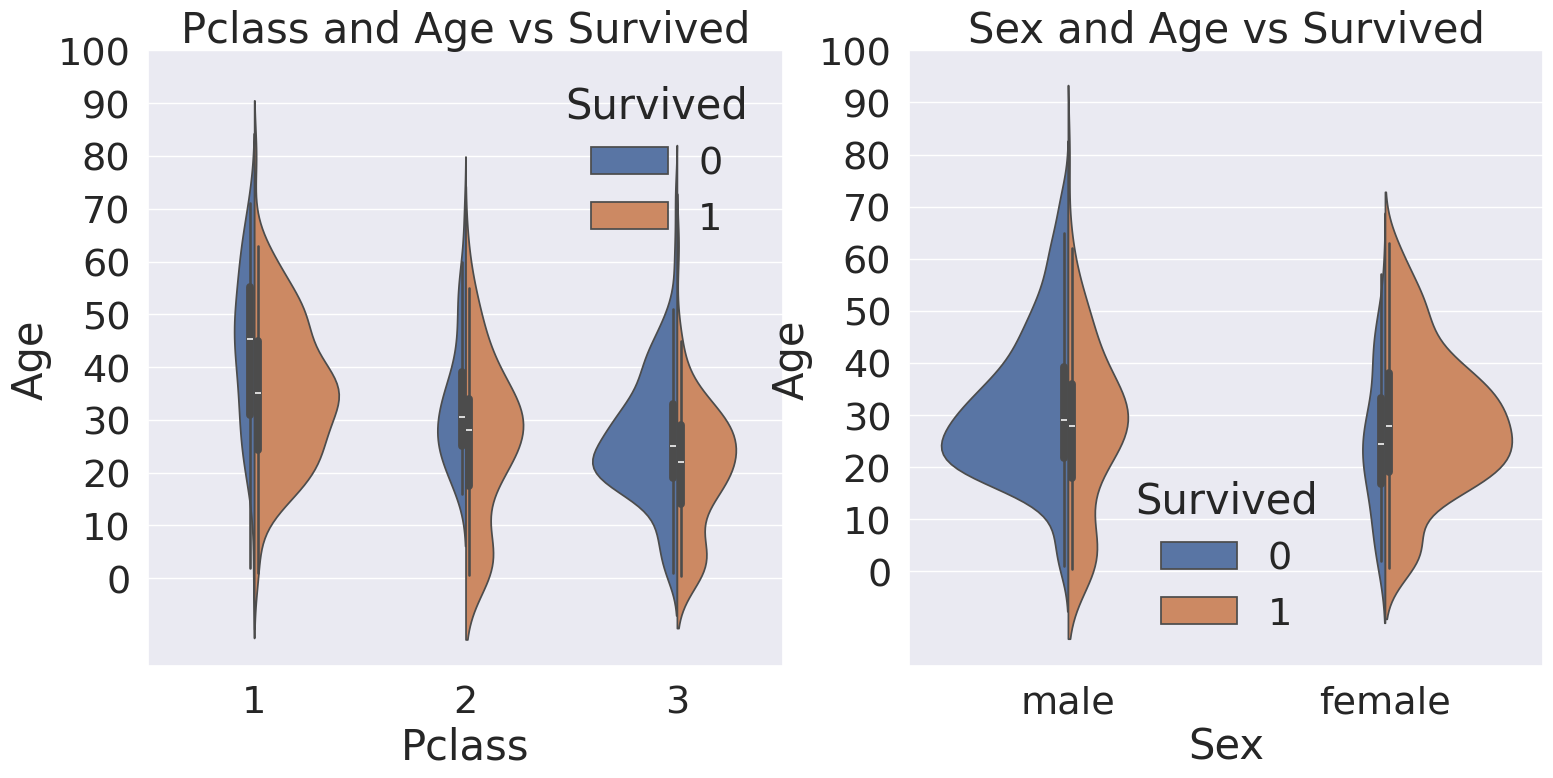

In [91]:
f, ax = plt.subplots(1, 2, figsize=(18, 8))
sns.violinplot(x="Pclass", y="Age", hue="Survived", data=df_train, scale='count', split=True, ax=ax[0])
ax[0].set_title('Pclass and Age vs Survived')
ax[0].set_yticks(range(0, 110, 10))
sns.violinplot(x="Sex", y="Age", hue="Survived", data=df_train,
               scale='count', split=True, ax=ax[1])
ax[1].set_title('Sex and Age vs Survived')
ax[1].set_yticks(range(0, 110, 10))
plt.show()

- 왼쪽 그림은 Pclass 별로 Age의 distribution이 어떻게 다른지, 그리고 생존 여부에 따라 구분한 그래프이다.
- 오른쪽 그림도 마찬가지 Sex, 생존에 따른 distribution이 어떻게 다른지 보여주는 그래프이다.
- 생존만 봤을 때, 모든 클래스에서 나이가 어릴 수록 생존을 많이 한 것을 볼 수 있다.
- 오른쪽 그림에서 보면, 명확히 여자가 생존을 많이 한 것을 볼 수 있다.
- **따라서 여성과 아이를 먼저 구한 것으로 생각할 수 있다.**